In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import warnings 
warnings.simplefilter(action = "ignore")

## 1. Data Analysis

In [2]:
# data is hosted at kaggle website. 
#https://www.kaggle.com/competitions/bigquery-geotab-intersection-congestion/data

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print ("shape of train dataset :", df_train.shape)
print ("shape of test dataset :", df_test.shape)

shape of train dataset : (856387, 28)
shape of test dataset : (1921357, 13)


In [4]:
df_train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


In [5]:
# train dataset info - 6 columns with text valuse and 22 with numeric values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856387 entries, 0 to 856386
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RowId                    856387 non-null  int64  
 1   IntersectionId           856387 non-null  int64  
 2   Latitude                 856387 non-null  float64
 3   Longitude                856387 non-null  float64
 4   EntryStreetName          848239 non-null  object 
 5   ExitStreetName           850100 non-null  object 
 6   EntryHeading             856387 non-null  object 
 7   ExitHeading              856387 non-null  object 
 8   Hour                     856387 non-null  int64  
 9   Weekend                  856387 non-null  int64  
 10  Month                    856387 non-null  int64  
 11  Path                     856387 non-null  object 
 12  TotalTimeStopped_p20     856387 non-null  float64
 13  TotalTimeStopped_p40     856387 non-null  float64
 14  Tota

,City,train,test
2,Chicago,131049,298129
0,Atlanta,156484,341852
1,Boston,178617,409275
3,Philadelphia,390237,872101


<AxesSubplot:xlabel='City', ylabel='value'>

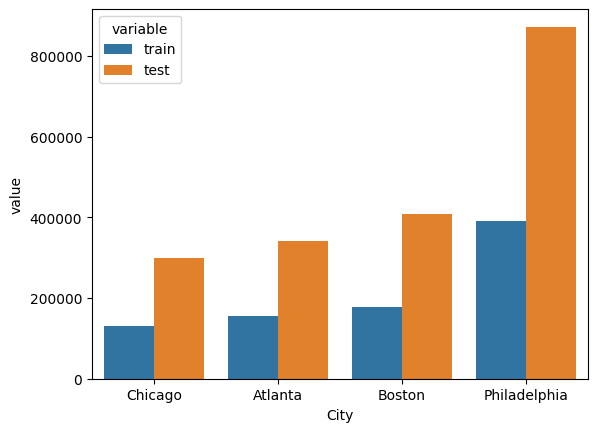

In [6]:
# Number of observations per "City" in Train & Test dataset - similar distribution of data per city 
train_city = df_train.groupby('City').size().reset_index().rename(columns={0:'train'})
test_city = df_test.groupby('City').size().reset_index().rename(columns={0:'test'})

data = train_city.merge(test_city, on='City').sort_values('test')
display (data)

sns.barplot(x='City',y='value',hue='variable',data=data.melt(id_vars='City', value_vars=['train','test']))

,City,train,test
0,Atlanta,377,468
1,Boston,975,1192
3,Philadelphia,1318,1715
2,Chicago,2135,2567


<AxesSubplot:xlabel='City', ylabel='value'>

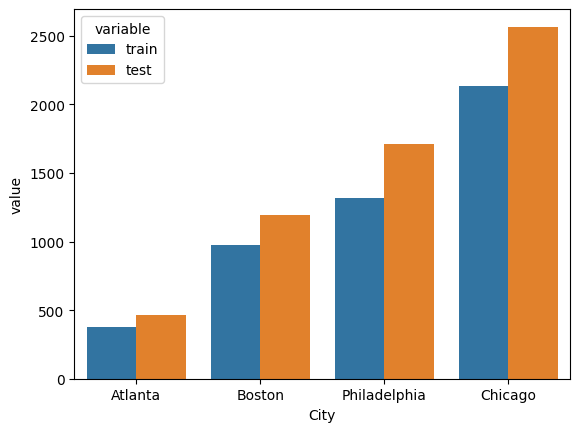

In [7]:
# Number of Intersections per City in Train & Test dataset - similar distribution of data per city 
train_intersection = df_train[['City', 'IntersectionId']].drop_duplicates().groupby('City').size().reset_index().rename(columns={0:'train'})
test_intersection = df_test[['City', 'IntersectionId']].drop_duplicates().groupby('City').size().reset_index().rename(columns={0:'test'})

data = train_intersection.merge(test_intersection, on='City').sort_values('train')
display(data)

sns.barplot(x='City',y='value',hue='variable',data=data.melt(id_vars='City', value_vars=['train','test']))

,Month,train,test
0,1,825,1725
1,5,175,345
2,6,109760,248749
3,7,110750,249488
4,8,122755,275063
5,9,124686,278813
6,10,133489,296985
7,11,124739,280501
8,12,129208,289688


<AxesSubplot:xlabel='Month', ylabel='value'>

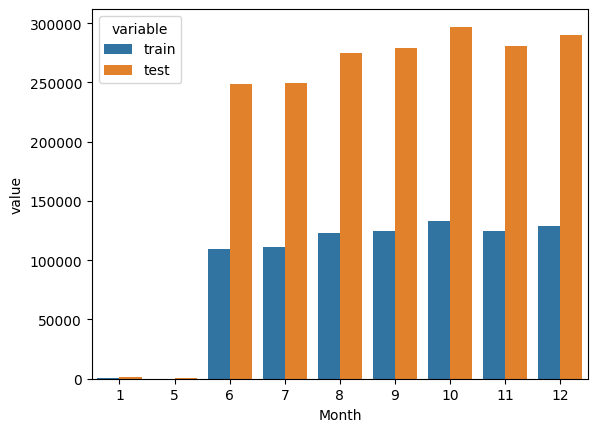

In [8]:
# Number of observation per Month in Train & Test dataset - Small about of data for Jan & May and missing data for Feb-Apr
train_months = df_train.groupby('Month').size().reset_index().rename(columns={0:'train'})
test_months = df_test.groupby('Month').size().reset_index().rename(columns={0:'test'})

data = train_months.merge(test_months, on='Month')
display(data)

sns.barplot(x='Month',y='value',hue='variable',data=data.melt(id_vars='Month', value_vars=['train','test']))

<AxesSubplot:xlabel='Hour', ylabel='value'>

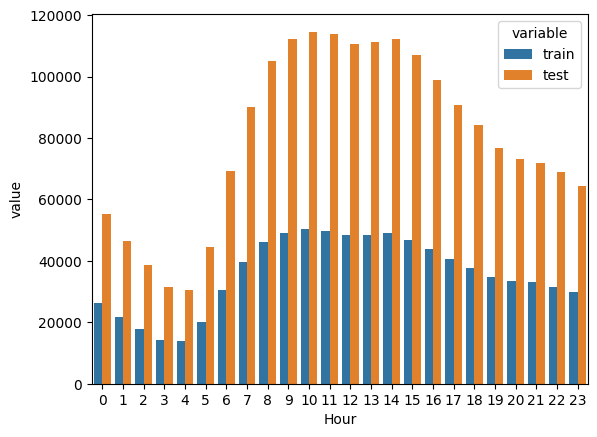

In [9]:
# Number of observation per Hour in Train & Test dataset - Similar distrbution of data in Train & Test datasets
train_hours = df_train.groupby('Hour').size().reset_index().rename(columns={0:'train'})
test_hours = df_test.groupby('Hour').size().reset_index().rename(columns={0:'test'})

data = train_hours.merge(test_hours, on='Hour')
#display(data)

sns.barplot(x='Hour',y='value',hue='variable',data=data.melt(id_vars='Hour', value_vars=['train','test']))

Both datasets have similar distrubtion of data for the 4 cities and for the same months

Now we will focus our analysis on the Train dataset

### Descriptive Statistics

**Train dataset includes :**
- Total time stopped = the amount of time spent at 0 speed
- Time from first stop = time from the first stop until the vehicle passes through the intersection
- Distance to first stop = the distance from the center of the intersection to the first stop, to give an idea of queue length

The data is presented in percentile 

In [10]:
# Descriptive statistics of the "Total time stopped"
df_train[['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
          'TotalTimeStopped_p60','TotalTimeStopped_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TotalTimeStopped_p20,856387.0,1.755596,7.146549,0.0,0.0,0.0,0.0,298.0
TotalTimeStopped_p40,856387.0,5.403592,12.981674,0.0,0.0,0.0,0.0,375.0
TotalTimeStopped_p50,856387.0,7.722655,15.685910,0.0,0.0,0.0,10.0,375.0
TotalTimeStopped_p60,856387.0,11.925195,19.761325,0.0,0.0,0.0,18.0,377.0
TotalTimeStopped_p80,856387.0,22.948621,28.274091,0.0,0.0,16.0,34.0,763.0


In [11]:
# Descriptive statistics of the "Time from first stop" 
df_train[['TimeFromFirstStop_p20','TimeFromFirstStop_p40', 'TimeFromFirstStop_p50','TimeFromFirstStop_p60',
          'TimeFromFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
TimeFromFirstStop_p20,856387.0,3.181096,11.835994,0.0,0.0,0.0,0.0,337.0
TimeFromFirstStop_p40,856387.0,9.162174,20.446568,0.0,0.0,0.0,0.0,356.0
TimeFromFirstStop_p50,856387.0,12.722165,24.219271,0.0,0.0,0.0,22.0,356.0
TimeFromFirstStop_p60,856387.0,18.926085,29.851797,0.0,0.0,0.0,31.0,357.0
TimeFromFirstStop_p80,856387.0,34.201656,41.130668,0.0,0.0,27.0,49.0,359.0


In [12]:
# Descriptive statistics of the "•Distance to first stop" 
df_train[['DistanceToFirstStop_p20','DistanceToFirstStop_p40', 'DistanceToFirstStop_p50','DistanceToFirstStop_p60',
 'DistanceToFirstStop_p80']].describe().T

,count,mean,std,min,25%,50%,75%,max
DistanceToFirstStop_p20,856387.0,6.765856,29.535968,0.0,0.0,0.0,0.00,1901.9
DistanceToFirstStop_p40,856387.0,20.285128,59.202108,0.0,0.0,0.0,0.00,2844.4
DistanceToFirstStop_p50,856387.0,28.837113,75.217343,0.0,0.0,0.0,53.10,2851.1
DistanceToFirstStop_p60,856387.0,44.272310,102.032250,0.0,0.0,0.0,64.20,3282.4
DistanceToFirstStop_p80,856387.0,83.991313,160.709797,0.0,0.0,60.4,85.95,4079.2


### Data Correlation

<AxesSubplot:>

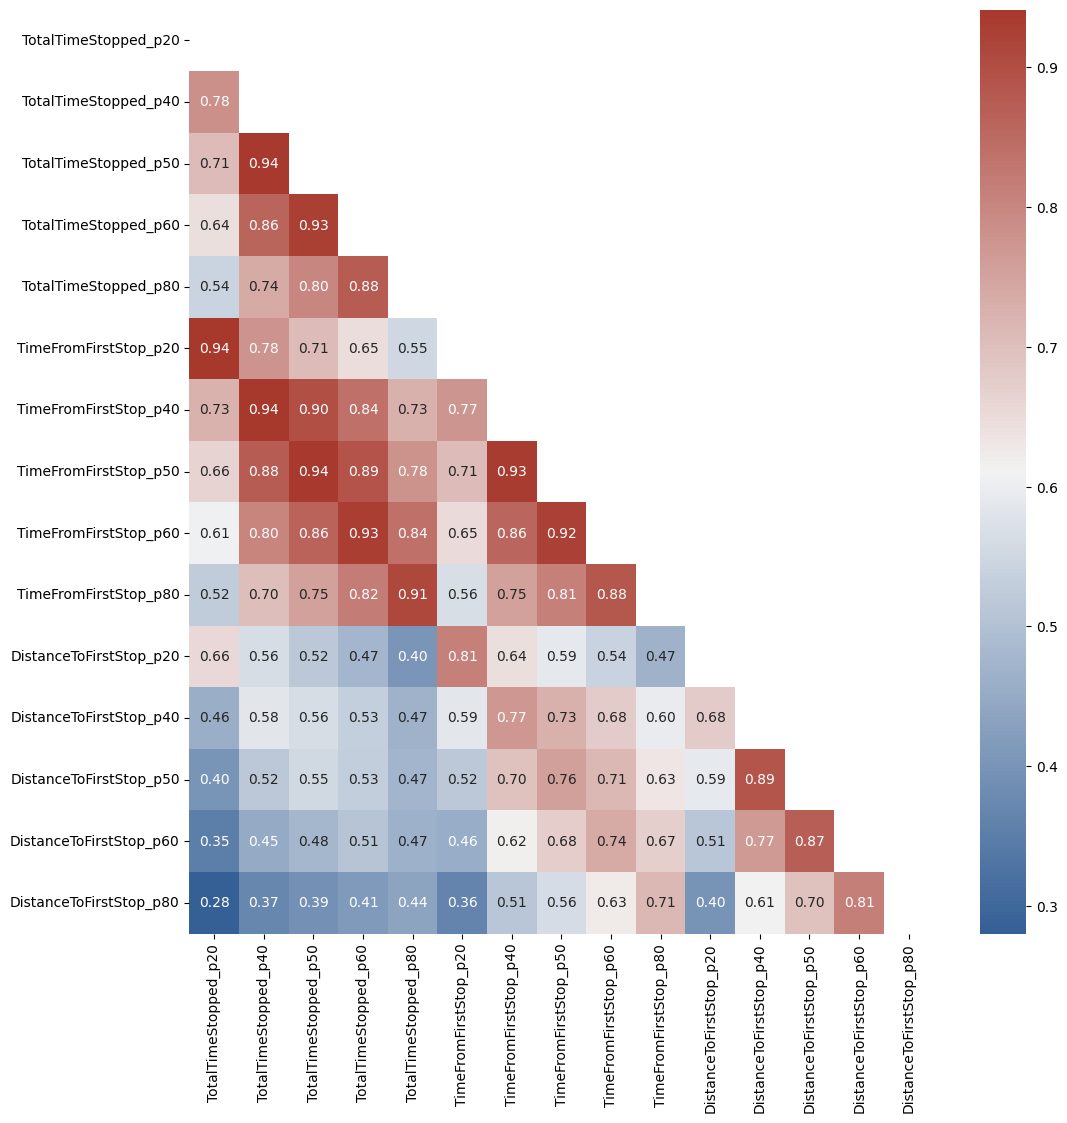

In [13]:
# Train correlation - "Total Time", "Time from First Stop" & "Distance from First Stop" are all postively correlated 
corr = df_train.iloc[:,12:-1].corr()
mask = np.triu(np.ones_like(corr,dtype=bool))
cmap = sns.diverging_palette(250,15,s=75,l=40, n=9, center='light', as_cmap=True)
fig = plt.figure(figsize=(12,12))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f')

## 2. Data Preprocessing


In [14]:
# check for Null Values in Train dataset - EntryStreetName & ExitStreetName are the only 2 columns with missing values 
df_train.isna().sum()

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [15]:
# check for Null Values in Test dataset - EntryStreetName & ExitStreetName are the only 2 columns with missing values 
df_test.isna().sum()

RowId                  0
IntersectionId         0
Latitude               0
Longitude              0
EntryStreetName    19198
ExitStreetName     15587
EntryHeading           0
ExitHeading            0
Hour                   0
Weekend                0
Month                  0
Path                   0
City                   0
dtype: int64

### Missing Observation Analysis

In [16]:
# check for Null Values in Train dataset - EntryStreetName & ExitStreetName are the only 2 columns with missing values 
df_train.isna().sum()

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [17]:
# Ratio of missing data in Train dataset
df_train[['EntryStreetName','ExitStreetName']].isna().sum() / df_train.shape[0]

EntryStreetName    0.009514
ExitStreetName     0.007341
dtype: float64

In [18]:
# check for Null Values in Test dataset - EntryStreetName & ExitStreetName are the only 2 columns with missing values 
df_test.isna().sum()

RowId                  0
IntersectionId         0
Latitude               0
Longitude              0
EntryStreetName    19198
ExitStreetName     15587
EntryHeading           0
ExitHeading            0
Hour                   0
Weekend                0
Month                  0
Path                   0
City                   0
dtype: int64

In [19]:
# Ratio of missing data in Test dataset
df_test[['EntryStreetName','ExitStreetName']].isna().sum() / df_test.shape[0]

EntryStreetName    0.009992
ExitStreetName     0.008112
dtype: float64

## 3. Feature Engineering

### Street Type

Street Type can affect traffic as smaller roads tend to be busier while wider roads tend to be faster. Street Type can be extracted from "Street Name". 

In [20]:
# We start by creating a columns to identify the type of the Street
#df_train['EntryStreetType'] = np.NaN
#df_train['ExitStreetType'] = np.NaN
#df_test['EntryStreetType'] = np.NaN
#df_test['ExitStreetType'] = np.NaN

str_code = ['Avenue','Street','Boulevard','Road','Highway','Drive','Parkway','Square','Way','Ave','St','Pkwy','Lane','Circle','Place','Other']
str_name = ['Avenue','Street','Boulevard','Road','Highway','Drive','Parkway','Square','Way','Avenue','Street','Parkway','Lane','Circle','Place','Other']

for st in range(len(str_code)):
    df_train.loc[~(df_train['EntryStreetName'].isna()) & (df_train['EntryStreetName'].str.contains(str_code[st])), 'EntryStreetType'] = str_name[st]
    df_train.loc[~(df_train['ExitStreetName'].isna()) & (df_train['ExitStreetName'].str.contains(str_code[st])), 'ExitStreetType'] = str_name[st]
    df_test.loc[~(df_test['EntryStreetName'].isna()) & (df_test['EntryStreetName'].str.contains(str_code[st])), 'EntryStreetType'] = str_name[st]
    df_test.loc[~(df_test['ExitStreetName'].isna()) & (df_test['ExitStreetName'].str.contains(str_code[st])), 'ExitStreetType'] = str_name[st]
    
df_train['EntryStreetType'].fillna('Other',inplace=True)
df_train['ExitStreetType'].fillna('Other',inplace=True)

df_test['EntryStreetType'].fillna('Other',inplace=True)
df_test['ExitStreetType'].fillna('Other',inplace=True)

### Number of Entries & Exits

Number of Entries and Exits of the intersection can affect the traffic and waiting time. This data will be extracted from "EntryHeading" & "ExitHeading".
We can create columns to identify the number of directions for each intersection. Then we add Number of Entries & Exits for each intersection


In [21]:
entry_data = df_train[['City','IntersectionId','EntryHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'EntryHeading':'count'}).reset_index().rename(columns={'EntryHeading':'EntryCount'})
exit_data = df_train[['City','IntersectionId','ExitHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'ExitHeading':'count'}).reset_index().rename(columns={'ExitHeading':'ExitCount'})

In [22]:
df_train = df_train.merge(entry_data, on=['City','IntersectionId'], how='left')
df_train = df_train.merge(exit_data, on=['City','IntersectionId'], how='left')
df_train.head()


,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2


In [23]:
# Replicate for Test dataset
entry_data = df_test[['City','IntersectionId','EntryHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'EntryHeading':'count'}).reset_index().rename(columns={'EntryHeading':'EntryCount'})
exit_data = df_test[['City','IntersectionId','ExitHeading']].drop_duplicates().groupby(['City','IntersectionId']).agg({'ExitHeading':'count'}).reset_index().rename(columns={'ExitHeading':'ExitCount'})

df_test = df_test.merge(entry_data, on=['City','IntersectionId'], how='left')
df_test = df_test.merge(exit_data, on=['City','IntersectionId'], how='left')
df_test.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount
0,0,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,0,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta,Street,Street,3,3
1,1,1,33.75094,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,Atlanta,Street,Street,3,3
2,2,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta,Street,Street,3,3
3,3,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta,Street,Street,3,3
4,4,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta,Street,Street,3,3


### EntryHeading & ExitHeading while keeping the sequence in order

In [24]:

heading_map = {'N':1,'NE':2,'E':3,'SE':4,'S':5, 'SW':6, 'W':7, 'NW': 8}

df_train['EntryHeading'] = df_train['EntryHeading'].map(heading_map)
df_train['ExitHeading'] = df_train['ExitHeading'].map(heading_map)
df_test['EntryHeading'] = df_test['EntryHeading'].map(heading_map)
df_test['ExitHeading'] = df_test['ExitHeading'].map(heading_map)

df_train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,0,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,1,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,2,0,...,0.0,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2


### Turn Type - difference between Exit & Entry

In [25]:
df_train['TurnType'] = df_train['ExitHeading'] - df_train['EntryHeading']
df_test['TurnType'] = df_test['ExitHeading'] - df_test['EntryHeading']
df_train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,0,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,0,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,1,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,4,4,1,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,8,8,2,0,...,0.0,0.0,0.0,0.0,Atlanta,Boulevard,Boulevard,3,2,0


## 4. Data Scaling

### Features to be used in modeling 

In [26]:
features = ['Hour', 'Weekend','EntryStreetType', 'ExitStreetType', 'EntryCount', 
            'ExitCount','TurnType','City']

_df_train = df_train[features]
_df_test = df_test[features]

### Encoding city name and street type


Categorical variables in the data set should be converted into numerical values. For this reason, these transformation processes are performed with Label Encoding

In [27]:
cities = ['Atlanta', 'Boston', 'Chicago', 'Philadelphia']
city_encoder = LabelEncoder().fit(cities)
_df_train.loc[:,'City'] = city_encoder.transform(_df_train['City'])
_df_test.loc[:,'City'] = city_encoder.transform(_df_test['City'])

StreetType = np.unique(_df_train['EntryStreetType'].unique().tolist() + _df_test['ExitStreetType'].unique().tolist()) 
street_encoder = LabelEncoder().fit(StreetType)
_df_train.loc[:,'EntryStreetType'] = street_encoder.transform(_df_train['EntryStreetType'])
_df_train.loc[:,'ExitStreetType'] = street_encoder.transform(_df_train['ExitStreetType'])
_df_test.loc[:,'EntryStreetType'] = street_encoder.transform(_df_test['EntryStreetType'])
_df_test.loc[:,'ExitStreetType'] = street_encoder.transform(_df_test['ExitStreetType'])

_df_train.head()

,Hour,Weekend,EntryStreetType,ExitStreetType,EntryCount,ExitCount,TurnType,City
0,0,0,1,1,3,2,0,0
1,0,0,1,1,3,2,0,0
2,1,0,1,1,3,2,0,0
3,1,0,1,1,3,2,0,0
4,2,0,1,1,3,2,0,0


We can improve the performance of the models by standardization. These are methods such as" Normalize"," MinMax"," Robust" and "Scale" that can be used for standardization

In [28]:
scaler = StandardScaler().fit(_df_train)
df_train_scaled = scaler.transform(_df_train)
df_test_scaled = scaler.transform(_df_test)

## 5. Base Models

Since this is a supervised regression problem, we will use regression models (LR/KNN/DT/RF) and comapare the results.

We will use Root Mean Squared Error (rmse) as a criteria to evaluate the performance of each model.

In [29]:
X = _df_train
y = df_train[['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
     'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Create function to run different models and return rmse
def modeling(X_train, X_test, y_train, y_test):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('DT', DecisionTreeRegressor(random_state = 1)))
    models.append(('RF', RandomForestRegressor(random_state = 1)))
    models.append(('GB', MultiOutputRegressor(GradientBoostingRegressor(random_state = 1))))

    #Evaluate each model in turn
    names = []
    rmses = []
    
    for name, model in models:
        model.fit (X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error (y_test, y_pred)
        rmse = np.sqrt(mse)
        print (f'{name} : mse {mse} - rmse {rmse}')
        names.append(name)
        rmses.append(rmse)
    return names, rmses

### Run modeling function on scaled data

In [31]:
print ("Scaled Data Modeling :")
names, rmses = modeling (X_train, X_test, y_train, y_test)

Scaled Data Modeling :
LR : mse 5336.049163036495 - rmse 73.0482659824071
KNN : mse 5497.62918385445 - rmse 74.1459991088828
DT : mse 4889.800447893909 - rmse 69.92710810475369
RF : mse 4740.139001866929 - rmse 68.84866739354459
GB : mse 5105.825940230371 - rmse 71.45506238350346


## 6. Model Tuning

Since RF performed the best in our initial testing, we will start by trying to tune the RF paramters

### Random Search

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid

In [33]:
#Random search
#Random Forest
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'n_estimators': sp_randint(10,100),
    'max_depth': sp_randint(5,50),
}
n_iter_search=20 
clf = RandomForestRegressor(random_state=1)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy',n_jobs = -1)
Random.fit(X_train, y_train)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))
best_estimator = Random.best_estimator_
y_pred = best_estimator.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse)

{'max_depth': 27, 'n_estimators': 53}
Accuracy:nan
mse : 4741.391198040265
rmse : 68.85776062318804


We now try grid search using approximately same parameters. We start with just two parameters number of estimators and max depth to reduce processing time.

In [34]:
rf_params = {
    'n_estimators': [10, 20, 30],
    'max_depth': [15,20,30,50],
}
clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf, rf_params, cv=3, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse) 

{'max_depth': 15, 'n_estimators': 30}
Accuracy:0.1712329415549402
mse : 4646.172082499638
rmse : 68.16283505327253


we can see 0.685 improvement in our rmse score. we can use best estimator paramters and try to find best value of min sample leaf paramter

In [35]:
rf_params = {
    'n_estimators': [30],
    'max_depth': [15],
    'min_samples_leaf': [9,10,11]
}
clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf, rf_params, cv=3, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse)

{'max_depth': 15, 'min_samples_leaf': 9, 'n_estimators': 30}
Accuracy:0.17297761919918123
mse : 4638.883183366004
rmse : 68.10934725400034


we can see more improvement in our rmse score. we can use best estimator paramters and try to find best value of min samples split paramter

In [36]:
rf_params = {
    'n_estimators': [30],
    'max_depth': [15],
    'min_samples_leaf': [9],
    'min_samples_split': [6]
}
clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf, rf_params, cv=3, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse)

{'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 30}
Accuracy:0.17297761919918123
mse : 4638.883183366004
rmse : 68.10934725400034


No more improvement in rmse score. lets try max feature parameter

In [37]:
rf_params = {
    'n_estimators': [30],
    'max_depth': [15],
    'min_samples_leaf': [9],
    'min_samples_split': [6],
    'max_features' :['sqrt',0.5]
}
clf = RandomForestRegressor(random_state=1)
grid = GridSearchCV(clf, rf_params, cv=3, n_jobs = -1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print("Accuracy:"+ str(grid.best_score_))
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse)

{'max_depth': 15, 'max_features': 0.9, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 30}
Accuracy:0.1749575347036997
mse : 4640.282477430402
rmse : 68.11961888788282


### using BayesSearchCV to further improve rmse score

In [42]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': Integer(30,31),
    "max_features":Integer(1,11),
    'max_depth': Integer(15,16),
    "min_samples_split":Integer(6,7),
    "min_samples_leaf":Integer(8,9)
}
#rf_params = {}
clf = RandomForestRegressor(random_state=1)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=10, n_jobs=-1,return_train_score = True)
Bayes.fit(X_train, y_train)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))
y_pred = bclf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse) 

OrderedDict([('max_depth', 16), ('max_features', 6), ('min_samples_leaf', 8), ('min_samples_split', 7), ('n_estimators', 30)])
Accuracy:0.18104164744348186
mse : 4611.426150498789
rmse : 67.90748228655505


### using Bayesian optimization on second best model(DecisionTreeRegressor) 

In [45]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
# Define the hyperparameter configuration space
rf_params = {
    "max_features":Integer(1,11),
    'max_depth': Integer(15,16),
    "min_samples_split":Integer(6,7),
    "min_samples_leaf":Integer(8,9)
}
#rf_params = {}
clf = DecisionTreeRegressor(random_state = 1)
Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=10, n_jobs=-1,return_train_score = True)
Bayes.fit(X_train, y_train)
print(Bayes.best_params_)
bclf = Bayes.best_estimator_
print("Accuracy:"+ str(Bayes.best_score_))
y_pred = bclf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
print ('mse :', rf_mse)
print ('rmse :', rf_rmse) 

OrderedDict([('max_depth', 16), ('max_features', 7), ('min_samples_leaf', 9), ('min_samples_split', 6)])
Accuracy:0.15783745366694993
mse : 4727.8826468717325
rmse : 68.75960039784795


### Final Score

by using Bayesian optimization we are able to reduce rmse to 67.90748228655505 and overall we improvement of 0.9412.